In [19]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

In [7]:
data = pd.read_csv('./Assets/data.csv', index_col = 'Date')
data = data.iloc[:2665, :]
data

,High,Low,Open,Close,Volume,Adj Close,pct_change,log_change,7ma,14ma,...,investment_dif,foreign_buy,foreign_sell,foreign_dif,FT_3components,FT_6components,FT_9components,FT_27components,FT_81components,FT_100components
Date,,,,,,,,,,,,,,,,,,,,,
2010/2/10,52.250000,51.700001,51.950001,52.099998,11219,52.099998,0.010669,0.010613,51.943241,52.708595,...,1454164689,1.551380e+10,2.549564e+10,-9981838210,96.358920,98.341083,94.157682,97.504515,95.290389,94.816094
2010/2/22,53.150002,52.599998,53.049999,52.599998,11187,52.599998,0.009597,0.009551,52.107470,52.693884,...,771651699,2.846749e+10,2.503619e+10,3431302085,96.242195,98.002049,93.597325,95.929373,90.414471,88.712660
2010/2/23,52.750000,52.200001,52.599998,52.599998,9571,52.599998,0.000000,0.000000,52.230624,52.681192,...,-387699136,2.422218e+10,2.360860e+10,613580581,96.125140,97.662731,93.037830,94.352361,85.604138,82.741271
2010/2/24,52.549999,52.150002,52.150002,52.250000,11026,52.250000,-0.006654,-0.006676,52.235469,52.623011,...,483080557,2.027639e+10,2.546846e+10,-5192069643,96.007757,97.323153,92.479275,92.775246,80.907607,76.994296
2010/2/25,52.299999,51.349998,52.250000,51.650002,20361,51.650002,-0.011483,-0.011550,52.089087,52.491931,...,-484640740,2.259238e+10,3.143820e+10,-8845826819,95.890048,96.983341,91.921743,91.199799,76.371194,71.557895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020/12/25,119.599998,118.599998,119.099998,118.949997,2801317,118.949997,0.001263,0.001262,118.587579,118.090677,...,373419980,2.930742e+10,2.403325e+10,5274170949,111.049753,127.320992,121.886350,124.377775,120.608542,121.100219
2020/12/28,120.000000,119.050003,119.050003,120.000000,3407442,120.000000,0.008827,0.008789,118.940684,118.345254,...,139024268,5.145881e+10,3.850894e+10,12949871214,111.054398,127.489588,122.247031,124.754413,121.300176,121.903124
2020/12/29,120.199997,119.349998,120.050003,119.900002,3093979,119.900002,-0.000833,-0.000834,119.180513,118.552554,...,-767399344,4.903891e+10,5.029541e+10,-1256508512,111.058523,127.656402,122.607526,125.124296,122.062133,122.757176


In [8]:
data['y'] = data['Close']

x = data.iloc[:, :59].values
y = data.iloc[:, 59].values

split = int(data.shape[0]* 0.8)
train_x, test_x = x[: split, :], x[split:, :]
train_y, test_y = y[: split, ], y[split: , ]

print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

x_scaler = MinMaxScaler(feature_range = (0, 1))
y_scaler = MinMaxScaler(feature_range = (0, 1))

train_x = x_scaler.fit_transform(train_x)
test_x = x_scaler.transform(test_x)

train_y = y_scaler.fit_transform(train_y.reshape(-1, 1))
test_y = y_scaler.transform(test_y.reshape(-1, 1))

trainX: (2132, 59) trainY: (2132,)
testX: (533, 59) testY: (533,)


In [9]:
class VAE(nn.Module):
    def __init__(self, config, latent_dim):
        super().__init__()

        modules = []
        for i in range(1, len(config)):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i - 1], config[i]),
                    nn.ReLU()
                )
            )
        
        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(config[-1], latent_dim)
        self.fc_var = nn.Linear(config[-1], latent_dim)

        modules = []
        self.decoder_input = nn.Linear(latent_dim, config[-1])

        for i in range(len(config) - 1, 1, -1):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i], config[i - 1]),
                    nn.ReLU()
                )
            )       
        modules.append(
            nn.Sequential(
                nn.Linear(config[1], config[0]),
                nn.Sigmoid()
            )
        ) 

        self.decoder = nn.Sequential(*modules)

    def encode(self, x):
        result = self.encoder(x)
        mu = self.fc_mu(result)
        logVar = self.fc_var(result)
        return mu, logVar

    def decode(self, x):
        result = self.decoder(x)
        return result

    def reparameterize(self, mu, logVar):
        std = torch.exp(0.5* logVar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, x):
        mu, logVar = self.encode(x)
        z = self.reparameterize(mu, logVar)
        output = self.decode(z)
        return output, z, mu, logVar

In [10]:
train_loader = DataLoader(TensorDataset(torch.from_numpy(train_x).float()), batch_size = 128, shuffle = False)
model = VAE([59, 400, 400, 400, 10], 10)

[1/300] Loss: 492.8373680114746
[2/300] Loss: 474.7328758239746
[3/300] Loss: 471.055570602417
[4/300] Loss: 469.01867866516113
[5/300] Loss: 462.4641799926758
[6/300] Loss: 459.0183734893799
[7/300] Loss: 459.58885383605957
[8/300] Loss: 451.5476417541504
[9/300] Loss: 447.9638900756836
[10/300] Loss: 454.0292739868164
[11/300] Loss: 445.2354316711426
[12/300] Loss: 433.6288604736328
[13/300] Loss: 436.87462615966797
[14/300] Loss: 440.3008556365967
[15/300] Loss: 437.4466381072998
[16/300] Loss: 433.95318031311035
[17/300] Loss: 430.4122085571289
[18/300] Loss: 426.84829330444336
[19/300] Loss: 423.27344703674316
[20/300] Loss: 419.72852897644043
[21/300] Loss: 416.2237911224365
[22/300] Loss: 412.77014923095703
[23/300] Loss: 409.36207580566406
[24/300] Loss: 405.92144203186035
[25/300] Loss: 402.44924545288086
[26/300] Loss: 398.9712314605713
[27/300] Loss: 395.55231380462646
[28/300] Loss: 392.21986198425293
[29/300] Loss: 388.97319316864014
[30/300] Loss: 385.7763891220093
[31/30

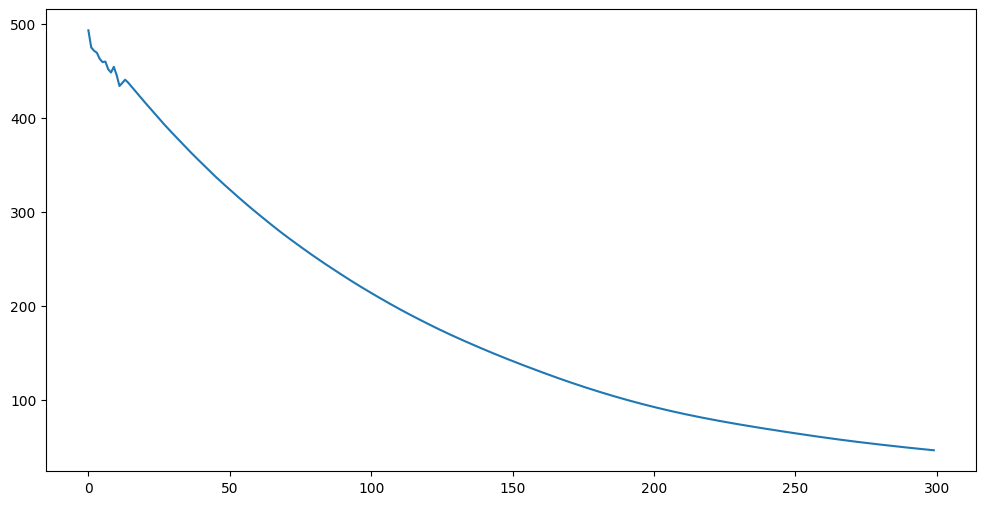

In [11]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
num_epochs = 300
learning_rate = 0.00003
model = model.to(device)   
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

hist = np.zeros(num_epochs) 
for epoch in range(num_epochs):
    total_loss = 0
    loss_ = []
    for (x, ) in train_loader:
        x = x.to(device)
        output, z, mu, logVar = model(x)
        kl_divergence = 0.5* torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = F.binary_cross_entropy(output, x) + kl_divergence
        loss.backward()
        optimizer.step()
        loss_.append(loss.item())
    hist[epoch] = sum(loss_)
    print('[{}/{}] Loss:'.format(epoch+1, num_epochs), sum(loss_))

plt.figure(figsize=(12, 6))
plt.plot(hist)

In [12]:
model.eval()
_, VAE_train_x, train_x_mu, train_x_var = model(torch.from_numpy(train_x).float().to(device))
_, VAE_test_x, test_x_mu, test_x_var = model(torch.from_numpy(test_x).float().to(device))

In [13]:
def sliding_window(x, y, window):
    x_ = []
    y_ = []
    y_gan = []
    for i in range(window, x.shape[0]):
        tmp_x = x[i - window: i, :]
        tmp_y = y[i]
        tmp_y_gan = y[i - window: i + 1]
        x_.append(tmp_x)
        y_.append(tmp_y)
        y_gan.append(tmp_y_gan)
    x_ = torch.from_numpy(np.array(x_)).float()
    y_ = torch.from_numpy(np.array(y_)).float()
    y_gan = torch.from_numpy(np.array(y_gan)).float()
    return x_, y_, y_gan

In [14]:
train_x = np.concatenate((train_x, VAE_train_x.cpu().detach().numpy()), axis = 1)
test_x = np.concatenate((test_x, VAE_test_x.cpu().detach().numpy()), axis = 1)

In [15]:
train_x_slide, train_y_slide, train_y_gan = sliding_window(train_x, train_y, 3)
test_x_slide, test_y_slide, test_y_gan = sliding_window(test_x, test_y, 3)
print(f'train_x: {train_x_slide.shape} train_y: {train_y_slide.shape} train_y_gan: {train_y_gan.shape}')
print(f'test_x: {test_x_slide.shape} test_y: {test_y_slide.shape} test_y_gan: {test_y_gan.shape}')


train_x: torch.Size([2129, 3, 69]) train_y: torch.Size([2129, 1]) train_y_gan: torch.Size([2129, 4, 1])
test_x: torch.Size([530, 3, 69]) test_y: torch.Size([530, 1]) test_y_gan: torch.Size([530, 4, 1])


In [16]:
class Generator(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.gru_1 = nn.GRU(input_size, 1024, batch_first = True)
        self.gru_2 = nn.GRU(1024, 512, batch_first = True)
        self.gru_3 = nn.GRU(512, 256, batch_first = True)
        self.linear_1 = nn.Linear(256, 128)
        self.linear_2 = nn.Linear(128, 64)
        self.linear_3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        use_cuda = 1
        device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
        h0 = torch.zeros(1, x.size(0), 1024).to(device)
        out_1, _ = self.gru_1(x, h0)
        out_1 = self.dropout(out_1)
        h1 = torch.zeros(1, x.size(0), 512).to(device)
        out_2, _ = self.gru_2(out_1, h1)
        out_2 = self.dropout(out_2)
        h2 = torch.zeros(1, x.size(0), 256).to(device)
        out_3, _ = self.gru_3(out_2, h2)
        out_3 = self.dropout(out_3)
        out_4 = self.linear_1(out_3[:, -1, :])
        out_5 = self.linear_2(out_4)
        out = self.linear_3(out_5)
        return out

In [18]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")

batch_size = 128
learning_rate = 0.000164
num_epochs = 300

trainDataloader = DataLoader(TensorDataset(train_x_slide, train_y_slide), batch_size = batch_size, shuffle = False)

model = Generator(69).to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

hist = np.zeros(num_epochs)
for epoch in range(num_epochs):
    loss_ = []
    y_pred = []
    for (x, y) in trainDataloader:
        x = x.to(device)
        y = y.to(device)
        y_train_pred = model(x)
        loss = criterion(y_train_pred, y)
        loss_.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    hist[epoch] = sum(loss_)
    print('[{}/{}] Loss:'.format(epoch+1, num_epochs), sum(loss_))



[1/300] Loss: 0.24765352625399828
[2/300] Loss: 2.0042214590939693
[3/300] Loss: 0.18380653811618686
[4/300] Loss: 0.3130647065117955
[5/300] Loss: 0.27124883118085563
[6/300] Loss: 0.17841555003542453
[7/300] Loss: 0.14891709497896954
[8/300] Loss: 0.19197358307428658
[9/300] Loss: 0.16467470326460898
[10/300] Loss: 0.03645504848100245
[11/300] Loss: 0.044293870276305825
[12/300] Loss: 0.04692159057594836
[13/300] Loss: 0.025927929033059627
[14/300] Loss: 0.02675633048056625
[15/300] Loss: 0.027200086129596457
[16/300] Loss: 0.024170957593014464
[17/300] Loss: 0.023715077782981098
[18/300] Loss: 0.026184806250967085
[19/300] Loss: 0.02870559538132511
[20/300] Loss: 0.02577775134705007
[21/300] Loss: 0.02652395362383686
[22/300] Loss: 0.03210584062617272
[23/300] Loss: 0.02892710512969643
[24/300] Loss: 0.028034098097123206
[25/300] Loss: 0.030234373756684363
[26/300] Loss: 0.02754825315787457
[27/300] Loss: 0.03802579327020794
[28/300] Loss: 0.03130855388008058
[29/300] Loss: 0.044308

Text(0.5, 0, 'Days')

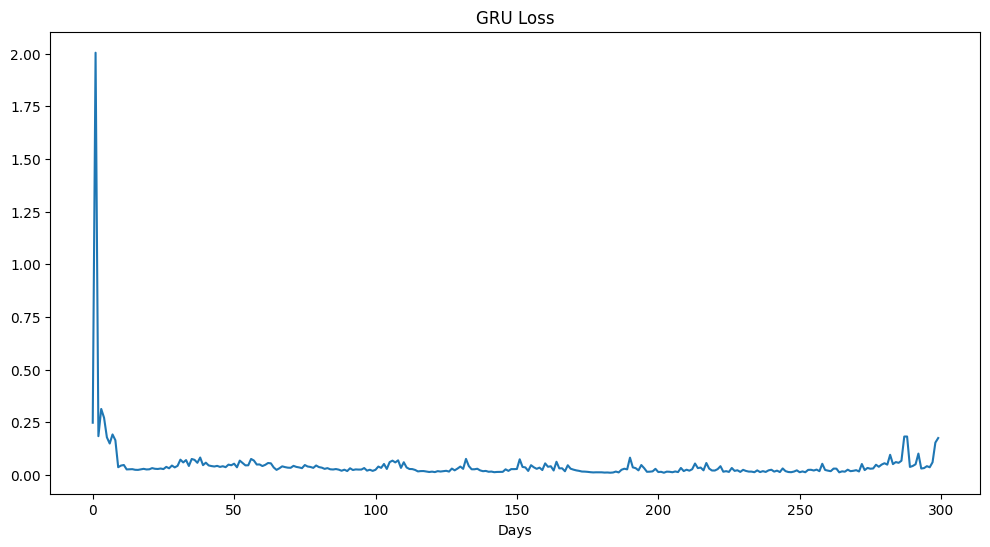

In [20]:
plt.figure(figsize = (12, 6))
plt.plot(hist, label = 'Loss')
plt.title('GRU Loss')
plt.xlabel('Days')


In [21]:
model.eval()
pred_y_train = model(train_x_slide.to(device))
pred_y_test = model(test_x_slide.to(device))

y_train_true = y_scaler.inverse_transform(train_y_slide)
y_train_pred = y_scaler.inverse_transform(pred_y_train.cpu().detach().numpy())

y_test_true = y_scaler.inverse_transform(test_y_slide)
y_test_pred = y_scaler.inverse_transform(pred_y_test.cpu().detach().numpy())

Training dataset RMSE:5.29427668712725


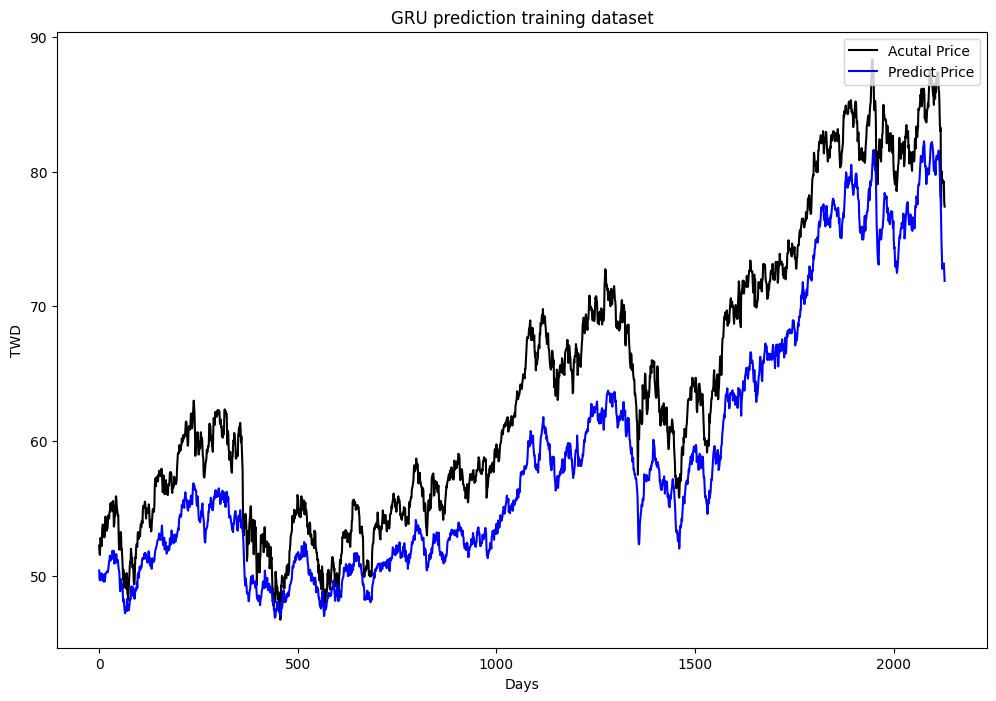

In [22]:
plt.figure(figsize=(12, 8))
plt.plot(y_train_true, color = 'black', label = 'Acutal Price')
plt.plot(y_train_pred, color = 'blue', label = 'Predict Price')
plt.title('GRU prediction training dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

Training dataset RMSE:8.164247692499568


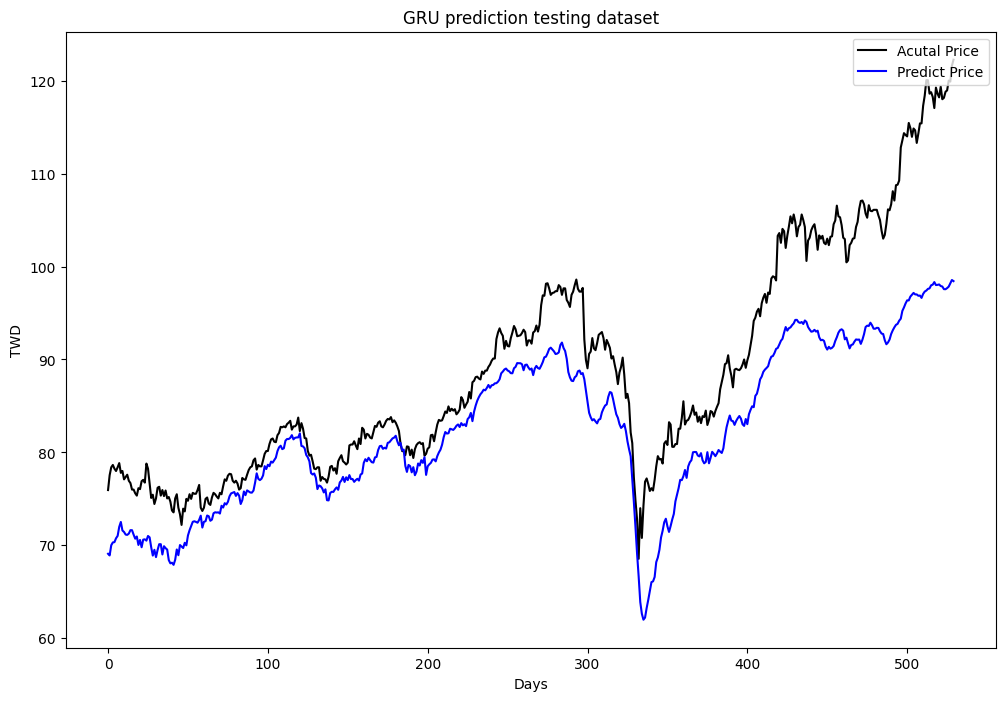

In [23]:
plt.figure(figsize=(12, 8))
plt.plot(y_test_true, color = 'black', label = 'Acutal Price')
plt.plot(y_test_pred, color = 'blue', label = 'Predict Price')
plt.title('GRU prediction testing dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')